# GraspGPT 模型推理与生成

本notebook用于从checkpoint加载GraspGPT模型，加载sequence序列数据，并进行token生成预测。

## 1. 导入必要的库和模块

In [1]:
import os
import sys
import json
import time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import deepspeed
from deepspeed import comm as dist

# 设置路径并导入graspGPT模块
current_dir = os.getcwd()
sys.path.append(current_dir)
sys.path.append(os.path.join(current_dir, 'graspGPT'))

from graspGPT.model.model import graspGPT
from graspGPT.model.utils import CfgNode as CN
from graspGPT.model.token_manager import get_token_manager, decode_sequence, encode_sequence
from graspGPT.model.parser_and_serializer import Serializer, Parser,Seq
from graspGPT.model.core import generate_amodal_sequence, generate_seg_sequence
from graspGPT.model.precomputed_dataset import PrecomputedDataset
import random

print("模块导入完成")

[2025-10-17 23:54:48,068] [INFO] [real_accelerator.py:260:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/wuminye/miniconda3/envs/grasp/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/wuminye/miniconda3/envs/grasp/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


[2025-10-17 23:54:50,111] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False
模块导入完成


## 2. 配置参数

In [2]:
# 设置参数
checkpoint_path = "output/checkpoints/exp21"  # 修改为实际的checkpoint路径
sequence_file = "output/scene_0000_objects_merged_aligned_seq.pth"  # 修改为align_coords.py生成的pth文件路径
deepspeed_config_path = "deepspeed_config.json"  # DeepSpeed配置文件路径

# 生成参数
max_new_tokens = 2000
temperature = 0.3
do_sample = True
top_k = None
num_sequences = 1
seed = 42

# 设置随机种子
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

print(f"Checkpoint路径: {checkpoint_path}")
print(f"序列文件路径: {sequence_file}")
print(f"生成参数: max_new_tokens={max_new_tokens}, temperature={temperature}")

Checkpoint路径: output/checkpoints/exp21
序列文件路径: output/scene_0000_objects_merged_aligned_seq.pth
生成参数: max_new_tokens=2000, temperature=0.3


## 3. 辅助函数定义

In [3]:
def parse_config_string(config_str):
    """解析字符串格式的配置到字典"""
    config_dict = {}
    for line in config_str.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()
            
            # 尝试解析值
            try:
                if value.lower() == 'true':
                    value = True
                elif value.lower() == 'false':
                    value = False
                elif value.lower() == 'none':
                    value = None
                elif value.startswith('(') and value.endswith(')'):
                    value = eval(value)
                elif value.startswith('[') and value.endswith(']'):
                    value = eval(value)
                elif '.' in value:
                    try:
                        value = float(value)
                    except ValueError:
                        pass
                else:
                    try:
                        value = int(value)
                    except ValueError:
                        pass
            except:
                pass
            
            config_dict[key] = value
    
    return config_dict

def load_training_config(checkpoint_dir):
    """从checkpoint目录加载训练配置"""
    # 尝试从training_state.json加载配置
    training_state_path = os.path.join(checkpoint_dir, 'training_state.json')
    if os.path.exists(training_state_path):
        with open(training_state_path, 'r') as f:
            training_state = json.load(f)
            if 'config' in training_state:
                config_data = training_state['config']
                
                if isinstance(config_data, dict):
                    parsed_config = {}
                    for section_name, section_value in config_data.items():
                        if isinstance(section_value, str):
                            parsed_config[section_name] = parse_config_string(section_value)
                        else:
                            parsed_config[section_name] = section_value
                    return CN.from_dict(parsed_config)
                else:
                    return CN.from_dict(config_data)
    
    # 备用：查找config.json文件
    search_dirs = [checkpoint_dir, os.path.dirname(checkpoint_dir)]
    config_names = ['config.json', 'training_config.json']
    
    for search_dir in search_dirs:
        for config_name in config_names:
            config_path = os.path.join(search_dir, config_name)
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config_dict = json.load(f)
                return CN.from_dict(config_dict)
    
    raise FileNotFoundError(f"未找到配置文件在 {checkpoint_dir} 或其父目录中")

print("辅助函数定义完成")

辅助函数定义完成


## 4. 第一部分：从checkpoint目录加载模型和参数

In [4]:
# 加载训练配置
print("正在加载训练配置...")
config = load_training_config(checkpoint_path)
print("训练配置加载成功")


config.model.tags = getattr(config.model, 'tags', CN())
config.model.tags.sort_unseg = getattr(config.model.tags, 'sort_unseg', False)
config.model.tags.add_unlabel_noise = getattr(config.model.tags, 'add_unlabel_noise', True)
config.model.tags.translation_argument = getattr(config.model.tags, 'translation_argument', False)
config.model.tags.translate_scale = getattr(config.model.tags, 'translate_scale', 5)


print(config.model.tags.sort_unseg) 

print(config.model.tags.add_unlabel_noise)

print(config.model.tags.translation_argument)



# 打印模型配置信息
print(f"模型类型: {getattr(config.model, 'model_type', 'custom')}")
print(f"词汇大小: {config.model.vocab_size}")
print(f"块大小: {config.model.block_size}")

# 修复模型配置以满足XOR条件
if hasattr(config.model, 'model_type') and config.model.model_type:
    if hasattr(config.model, 'n_layer'):
        config.model.n_layer = None
    if hasattr(config.model, 'n_head'):
        config.model.n_head = None  
    if hasattr(config.model, 'n_embd'):
        config.model.n_embd = None

正在加载训练配置...
训练配置加载成功
False
True
False
模型类型: gpt2
词汇大小: 147219
块大小: 16384


In [5]:
# 获取token管理器和词汇表
print("正在获取token管理器...")
token_manager = get_token_manager()

# 生成token映射
img_h, img_w, img_d =80, 54, 34  # 默认体积维度
config.dataset.data_path = 'output/precomputed_data/'
# 尝试从数据中获取实际维度
if hasattr(config.dataset, 'data_path') and config.dataset.data_path:
    import glob
    data_files = glob.glob(os.path.join(config.dataset.data_path, "*.pth"))
    if data_files:
        sample_file = data_files[0]
        print(f"从样本文件获取体积维度: {os.path.basename(sample_file)}")
        raw_data = torch.load(sample_file, weights_only=False)
        if 'volume_dims' in raw_data:
            img_h, img_w, img_d = raw_data['volume_dims']
            print(f"从数据获取的体积维度: {img_h}x{img_w}x{img_d}")

token_mapping = token_manager.generate_mapping(img_h, img_w, img_d)
vocab_size = len(token_mapping)

# 更新配置中的词汇大小
config.model.vocab_size = vocab_size

print(f"Token管理器词汇大小: {vocab_size}")
print(f"使用的体积维度: {img_h}x{img_w}x{img_d}")

正在获取token管理器...
从样本文件获取体积维度: precomputed_batch_36024_0.pth
Token管理器词汇大小: 147219
使用的体积维度: 80x54x34


In [6]:
# 创建模型
print("正在创建模型...")
model = graspGPT(config.model)
param_count = sum(p.numel() for p in model.parameters()) / 1e6
print(f"模型创建完成: {param_count:.2f}M 参数")

# 加载DeepSpeed配置
print("正在加载DeepSpeed配置...")
with open(deepspeed_config_path, 'r') as f:
    ds_config = json.load(f)

# 配置推理模式
ds_config.update({
    "train_batch_size": 1,
    "train_micro_batch_size_per_gpu": 1,
    "gradient_accumulation_steps": 1,
})

if ds_config.get("bf16", {}).get("enabled", False):
    print("bf16已启用用于推理")

print("DeepSpeed配置加载完成")

You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour


正在创建模型...
Using Qwen2 model with RoPE position encoding
number of parameters: 216.91M
模型创建完成: 216.91M 参数
正在加载DeepSpeed配置...
bf16已启用用于推理
DeepSpeed配置加载完成


In [7]:
# 加载checkpoint
print(f"正在加载checkpoint: {checkpoint_path}")

# 解析checkpoint路径
if os.path.isfile(checkpoint_path):
    parent_dir = os.path.dirname(checkpoint_path)
    tag = os.path.basename(checkpoint_path)
elif os.path.isdir(checkpoint_path):
    parent_dir = os.path.dirname(checkpoint_path)
    tag = os.path.basename(checkpoint_path)
else:
    raise ValueError(f"Checkpoint路径不存在: {checkpoint_path}")

# 尝试使用DeepSpeed加载
try:
    # 初始化DeepSpeed引擎用于推理
    model_engine, _, _, _ = deepspeed.initialize(
        model=model,
        config=ds_config,
        model_parameters=model.parameters()
    )
    
    # 加载checkpoint
    _, client_state = model_engine.load_checkpoint(parent_dir, tag=tag)
    print(f"使用DeepSpeed成功加载checkpoint")
    
except Exception as e:
    print(f"DeepSpeed加载失败: {e}")
    print("回退到PyTorch加载...")
    
    # 回退：使用常规PyTorch加载
    checkpoint_file = os.path.join(checkpoint_path, 'mp_rank_00_model_states.pt')
    if os.path.exists(checkpoint_file):
        print(f"使用PyTorch从以下位置加载checkpoint: {checkpoint_file}")
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        checkpoint = torch.load(checkpoint_file, map_location=device)
        
        state_dict = checkpoint.get('module', checkpoint)
        model.load_state_dict(state_dict, strict=False)
        
        if torch.cuda.is_available():
            model = model.cuda()
        
        print(f"使用PyTorch成功加载checkpoint")
        
        # 创建模型包装器以兼容DeepSpeed接口
        class ModelWrapper:
            def __init__(self, model):
                self.module = model
                self.model = model
                self.local_rank = 0
                
            def eval(self):
                self.module.eval()
                
            def __call__(self, *args, **kwargs):
                return self.module(*args, **kwargs)
        
        model_engine = ModelWrapper(model)
    else:
        raise ValueError(f"找不到checkpoint文件: {checkpoint_file}")

print("模型加载完成！")

正在加载checkpoint: output/checkpoints/exp21
[2025-10-17 23:54:55,073] [INFO] [logging.py:107:log_dist] [Rank -1] DeepSpeed info: version=0.17.5, git-hash=unknown, git-branch=unknown
[2025-10-17 23:54:55,074] [INFO] [comm.py:821:init_distributed] cdb=None
[2025-10-17 23:54:55,074] [INFO] [comm.py:836:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2025-10-17 23:54:55,375] [INFO] [comm.py:891:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.24.93.140, master_port=29500
[2025-10-17 23:54:55,376] [INFO] [comm.py:852:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2025-10-17 23:54:55,416] [INFO] [config.py:684:__init__] Config mesh_device None world_size = 1
[2025-10-17 23:54:55,678] [INFO] [engine.py:1356:_configure_distributed_model] ********** distributed groups summary **********
	 self.dp_world_size=1
	 self.mp_world_size=1
	 self.seq_dp_world_size=1
	 self.

Using /home/wuminye/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/wuminye/.cache/torch_extensions/py310_cu118/fused_adam/build.ninja...
/home/wuminye/miniconda3/envs/grasp/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load fused_adam op: 0.016573429107666016 seconds
[2025-10-17 23:54:55,814] [INFO] [logging.py:107:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2025-10-17 23:54:55,814] [INFO] [logging.py:107:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-10-17 23:54:55,817] [INFO] [logging.py:107:log_dist] [Rank 0] DeepSpeed Basic Optimizer = FusedAdam
[2025-10-17 23:54:55,818] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=FusedAdam type=<class 'deepspeed.ops.adam.fused_adam.FusedAdam'>
[2025-10-17 23:54:55,818] [INFO] [logging.py:107:log_dist] [Rank 0] Creating torch.bfloat16 ZeRO stage 1 optimizer
[2025-10-17 23:54:55,819] [INFO] [stage_1_and_2.py:178:__init__] Reduce bucket size 500000000
[2025-10-17 23:54:55,819] [INFO] [stage_1_and_2.py:179:__init__] Allgather bucket size 500000000
[2025-10-17 23:54:55,819] [INFO] [stage_1_and_2.py:180:__init__] CPU O

Loading extension module fused_adam...


[2025-10-17 23:54:56,256] [INFO] [utils.py:781:see_memory_usage] Before initializing optimizer states
[2025-10-17 23:54:56,257] [INFO] [utils.py:782:see_memory_usage] MA 1.21 GB         Max_MA 1.62 GB         CA 1.62 GB         Max_CA 2 GB 
[2025-10-17 23:54:56,258] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 4.41 GB, percent = 18.0%
[2025-10-17 23:54:56,460] [INFO] [utils.py:781:see_memory_usage] After initializing optimizer states
[2025-10-17 23:54:56,461] [INFO] [utils.py:782:see_memory_usage] MA 1.21 GB         Max_MA 2.02 GB         CA 2.43 GB         Max_CA 2 GB 
[2025-10-17 23:54:56,462] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 4.41 GB, percent = 18.0%
[2025-10-17 23:54:56,463] [INFO] [stage_1_and_2.py:605:__init__] optimizer state initialized
[2025-10-17 23:54:56,637] [INFO] [utils.py:781:see_memory_usage] After initializing ZeRO optimizer
[2025-10-17 23:54:56,638] [INFO] [utils.py:782:see_memory_usage] MA 1.21 GB         Max_MA 

## 5. 第二部分：从外部pth文件加载sequence序列

In [8]:
dataset = PrecomputedDataset(
    data_path='output/real_data/test_m15_pths',
    max_sequence_length=config.dataset.max_sequence_length,
    tags = config.model.tags
)

print(getattr(config.dataset, 'real_filter_mode', 'allow_all'))

Loading test_m15_real_pths.pth...
Loaded 50 precomputed samples from 1 files
Memory optimized: sorted by length, using numpy arrays with appropriate dtypes
allow_all


In [31]:
dataset = PrecomputedDataset(
    data_path='output/real_data/tmp',
    max_sequence_length=config.dataset.max_sequence_length,
    real_filter_mode=getattr(config.dataset, 'real_filter_mode', 'allow_all'),
    apply_del_amodal_sequence = True
)

print(getattr(config.dataset, 'real_filter_mode', 'allow_all'))

Loading precomputed_batch_36024_8.pth...
Loaded 3000 precomputed samples from 1 files
Memory optimized: sorted by length, using numpy arrays with appropriate dtypes
amodal_only


# --------------(training data

In [9]:


# 加载序列数据
sequence_data,lens, loss_mask = dataset.__getitem__(0)
    
sequence_data = sequence_data.squeeze().numpy()

print(sequence_data)



print(f"使用键 raw_tokens 作为token序列")

token_sequence = decode_sequence(sequence_data, token_mapping)
#parser = Parser(token_sequence)
#token_sequence = parser.parse()
#print(len(token_sequence.items))


[   91     1   477 ... 58182 48934    98]
使用键 raw_tokens 作为token序列


## 6. 第三部分：在序列尾部加入新的指定tokens作为prompt，让model接下去预测

## Grasp prediction

In [10]:
gt_tokens = token_sequence
scene_promt = encode_sequence(token_sequence, token_mapping)

scene_promt = scene_promt[:scene_promt.index(token_mapping['detectgrasp'])+1]
print(len(scene_promt),scene_promt[-10:])

# 指定要添加到序列尾部的tokens作为prompt
# 这里可以根据需要修改，例如添加特定的命令tokens
additional_tokens = [
    #token_mapping['detectgrasp'],  # 检测抓取命令
    token_mapping['grasp'],         # 抓取命令
    #token_mapping['object24']
]

print(f"要添加的tokens: {additional_tokens}")
print(f"对应的token名称: {[k for k, v in token_mapping.items() if v in additional_tokens]}")

# 将新的tokens添加到序列尾部
prompt_sequence = scene_promt + additional_tokens
#prompt_sequence = scene_promt

print(f"添加prompt后的序列长度: {len(prompt_sequence)}")
print(f"完整prompt序列的最后20个tokens: {prompt_sequence[-20:]}")

2284 [143787, 145523, 145524, 145557, 145558, 145589, 145590, 145591, 145592, 96]
要添加的tokens: [97]
对应的token名称: ['grasp']
添加prompt后的序列长度: 2285
完整prompt序列的最后20个tokens: [143687, 143688, 143689, 143722, 143723, 143753, 143754, 143755, 143756, 143787, 145523, 145524, 145557, 145558, 145589, 145590, 145591, 145592, 96, 97]


## Amodal

In [12]:
tokens = token_sequence
gt_tokens = tokens
tokens = tokens[:tokens.index("unlabel")+1]
prompt_sequence = encode_sequence(tokens, token_mapping)
print(len(tokens),len(gt_tokens))

2 3829


## UNSEG

In [10]:
tokens = token_sequence
gt_tokens = tokens
tokens = tokens[:tokens.index("segment")+1]
prompt_sequence = encode_sequence(tokens, token_mapping)
print(len(tokens),len(gt_tokens))

1444 3400


## do prediction

In [11]:
# 准备输入张量
def prepare_input_from_tokens(token_ids, max_length=None):
    """从token ID列表准备输入"""
    if not token_ids:
        raise ValueError("提供的token ID列表为空")
    
    # 转换为张量
    input_ids = torch.tensor([token_ids], dtype=torch.long)
    
    # 如果需要，进行截断
    if max_length and input_ids.size(1) > max_length:
        input_ids = input_ids[:, -max_length:]
    
    return input_ids

# 准备输入
input_ids = prepare_input_from_tokens(prompt_sequence, config.model.block_size)
input_ids = input_ids.repeat(2,1)
original_length = input_ids.size(1)

print(f"输入张量形状: {input_ids.shape}")
print(f"原始序列长度: {original_length}")

输入张量形状: torch.Size([2, 2285])
原始序列长度: 2285


In [12]:
# 配置生成参数
generation_config = {
    'max_new_tokens': max_new_tokens+1500,
    'temperature': temperature*2,
    'do_sample': do_sample,
    'top_k': top_k,
    'eos_token_id': token_mapping.get('end', None)
}

print(f"生成配置: {generation_config}")

生成配置: {'max_new_tokens': 3500, 'temperature': 0.6, 'do_sample': True, 'top_k': None, 'eos_token_id': 98}


In [13]:
# 执行生成
def generate_with_model(model_engine, input_ids, generation_config):
    """使用模型生成序列"""
    # 将输入移动到正确的设备
    if hasattr(model_engine, 'local_rank') and model_engine.local_rank is not None:
        device = f'cuda:{model_engine.local_rank}'
    else:
        # 回退：从模型参数获取设备
        device = next(model_engine.module.parameters()).device
    
    input_ids = input_ids.to(device)
    
    # 将模型设置为评估模式
    model_engine.eval()
    
    with torch.no_grad():
        # 生成序列
        if hasattr(model_engine.module, 'generate'):
            generated = model_engine.module.generate_ori(
                idx=input_ids,
                max_new_tokens=generation_config.get('max_new_tokens', 50),
                temperature=generation_config.get('temperature', 1.0),
                do_sample=generation_config.get('do_sample', True),
                top_k=generation_config.get('top_k', None),
                end_token=generation_config.get('eos_token_id', None),
                #allow_unseg = True
            )
        else:
            raise ValueError("模型没有generate方法")
    
    return generated

print("开始生成...")
start_time = time.time()

print("输入长度:",input_ids.size())
# 执行生成
generated = generate_with_model(model_engine, input_ids, generation_config)

generation_time = time.time() - start_time

print(f"生成完成，耗时: {generation_time:.2f}秒")
print(f"生成的序列长度: {generated.size(1)} tokens. {generated.size()}")

开始生成...
输入长度: torch.Size([2, 2285])
生成完成，耗时: 58.33秒
生成的序列长度: 5785 tokens. torch.Size([2, 5785, 1])


In [14]:
from extract_sample_and_export import visualize_tokens

all_scene  = generated.squeeze().detach().cpu()
all_scene[:,-1] = token_mapping.get('end', None)
for i in range(all_scene.size(0)):
    visualize_tokens(all_scene[i], token_mapping, volume_dims =(img_h, img_w, img_d), bbox_min = np.array([-0.3, -0.2, 0]), voxel_size = 0.0075, output_dir = f'./output/tokens_visual/{i}')


visualize_tokens(encode_sequence(gt_tokens, token_mapping), token_mapping, volume_dims =(img_h, img_w, img_d), bbox_min = np.array([-0.3, -0.2, 0]), voxel_size = 0.0075, output_dir = f'./output/tokens_visual/gt')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
=== 开始可视化tokens ===
正在转换token ids到序列...
解码得到的tokens数量: 5785
前10个tokens: ['scene', 'unlabel', (0, 4, 2), (2, 4, 2), (2, 5, 2), (4, 4, 2), (4, 5, 2), (5, 4, 2), (6, 4, 2), (9, 4, 3)]
解析成功，序列包含 2 个项目
体素信息: dims=(80, 54, 34), bbox_min=[-0.3 -0.2  0. ], voxel_size=0.0075
正在按类别提取点云...
Scene SB 'unlabel': 2281 个点
合并scene点云: 2281 个点
amodal 类别没有点云
unseg 类别没有点云
合并grasp点云: 2100 个点
已生成并保存 700 个抓取mesh，目录: output/tokens_visual/0/grasp_meshes
tokens可视化完成，结果保存在: output/tokens_visual/0
=== 开始可视化tokens ===
正在转换token ids到序列...
解码得到的tokens数量: 5785
前10个tokens: ['scene', 'unlabel', (0, 4, 2), (2, 4, 2), (2, 5, 2), (4, 4, 2), (4, 5, 2), (5, 4, 2), (6, 4, 2), (9, 4, 3)]
解析成功，序列包含 2 个项目
体素信息: dims=(80, 54, 34), bbox_min=[-0.3 -0.2  0. ], voxel_size=0.0075
正在按类别提取点云...
Scene SB 'unlabel': 2281 个点
合并scene点云: 2281 个点
amodal 类别没有点云
unseg 类别没有点云
合并g

PosixPath('output/tokens_visual/gt')

In [ ]:
print(decode_sequence(generated[0].cpu().squeeze().numpy().tolist(),token_mapping))

In [ ]:
print(tokens)

In [ ]:
# 完整序列（原始 + prompt + 生成）
full_sequence = input_ids[0].cpu().numpy().tolist() + decoded_tokens

print(f"完整序列长度: {len(full_sequence)}")
print(f"完整序列的最后30个tokens: {full_sequence[-30:]}")

# 保存结果
result = {
    'original_sequence_length': len(token_sequence),
    'prompt_tokens': additional_tokens,
    'input_length': original_length,
    'generated_tokens': decoded_tokens,
    'generated_token_names': decoded_names,
    'total_length': len(full_sequence),
    'generation_time': generation_time,
    'generation_config': generation_config,
    'full_sequence': full_sequence
}

print("\n=== 生成结果总结 ===")
print(f"原始序列长度: {result['original_sequence_length']}")
print(f"添加的prompt tokens: {result['prompt_tokens']}")
print(f"输入长度: {result['input_length']}")
print(f"生成的新tokens: {result['generated_tokens']}")
print(f"生成时间: {result['generation_time']:.2f}秒")

## 7. 可选：可视化生成结果

In [11]:
x = torch.tensor(sequence_data).unsqueeze(0).unsqueeze(-1).cuda().int()
y = x[:,1:,:]
x = x[:,:-1,:]
loss_mask_a = loss_mask[1:]
print(x.shape)
print(loss_mask.shape)
model_engine.module.eval()
res = model_engine.module.forward(x, targets=y, loss_mask= loss_mask_a)
print(res[0])

torch.Size([1, 4457, 1])
torch.Size([4458])
[tensor([[[-7.6875,  9.9375, -7.6875,  ..., -7.6875, -7.6875, -7.6875],
         [-4.9688, -7.8438, -4.9688,  ..., -4.9688, -4.9688, -4.9688],
         [-2.8125,  1.6172, -2.7969,  ..., -2.7969, -2.7969, -2.7969],
         ...,
         [-7.8125, -3.8594, -7.8125,  ..., -7.8125, -7.8125, -7.8125],
         [-5.9062, -2.7500, -5.9062,  ..., -5.9062, -5.9062, -5.9062],
         [-5.3125, -0.0957, -5.3125,  ..., -5.3125, -5.3125, -5.3125]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)]


In [12]:
print(res[1])

tensor(2.3594, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)


## 8. 保存结果到文件

In [13]:
import torch.nn.functional as F
def analyze_token_confidence_and_contrast(
    logits: torch.Tensor,
    gt_token_ids: torch.Tensor,
    pad_token_id: int = -1,
    eps: float = 1e-12,
):
    """
    对每个 token 计算自信度与“对比度”（正确答案 vs. 其他可能）。
    
    参数：
        logits: [B, L, V]  模型输出的 logits
        gt_token_ids: [B, L]  对齐的 ground-truth token id
        pad_token_id: (可选) 若提供，则按此 id 进行 mask 聚合
        eps: 数值稳定用

    返回：
        result: dict，包含以下同形张量（除聚合统计字段外均为 [B, L] 或相应 dtype）
            - confidence: p(gt)
            - top1_id: argmax token id
            - top1_prob: 最大概率
            - correct_top1: bool，是否 top-1 命中 gt
            - rank: int，gt 的排名（1=第一）
            - competitor_id: 除 gt 外概率最大的 token id
            - competitor_prob: 其概率
            - margin_prob: p(gt) - p(competitor)
            - margin_logit: z(gt) - z(competitor)
            - log_ratio: log( p(gt) / p(competitor) )
            - ratio_to_other: p(gt) / (p(competitor)+eps)
            - is_overruled: bool，是否被“错误答案”压过（== top1!=gt）
            - mask: bool，非 pad 的有效位置
            - summary: dict，聚合统计（忽略 pad）
                * mean_confidence
                * overruled_rate
                * mean_margin_prob
                * mean_margin_logit
                * mean_log_ratio
                * mean_rank
    """
    B, L, V = logits.shape
    gt = gt_token_ids[...,0].long()

    # 概率与对数概率（一次性算好，避免重复 softmax）
    log_probs = F.log_softmax(logits, dim=-1)      # [B, L, V]
    probs = log_probs.exp()                        # [B, L, V]

    # p(gt)、log p(gt)、z(gt)
    gather_idx = gt.unsqueeze(-1)                  # [B, L, 1]
    p_gt = torch.gather(probs, -1, gather_idx).squeeze(-1)           # [B, L]
    logp_gt = torch.gather(log_probs, -1, gather_idx).squeeze(-1)    # [B, L]
    z_gt = torch.gather(logits, -1, gather_idx).squeeze(-1)          # [B, L]

    # top-1（全体最大）
    top1_prob, top1_id = probs.max(dim=-1)         # [B, L], [B, L]
    correct_top1 = top1_id.eq(gt)

    # competitor（除 gt 外的最大者）
    # 做法：把 gt 位置屏蔽为 -inf（对 logits），然后找最大；这样既能拿到 prob，也能拿到 logit 差
    neg_inf = torch.finfo(logits.dtype).min
    logits_others = logits.clone()
    # 利用 scatter_ 在 gt 处写入 -inf
    logits_others.scatter_(-1, gather_idx, neg_inf)
    # 其他候选的最大 logit 及其 id
    z_other, competitor_id = logits_others.max(dim=-1)               # [B, L]
    # 对应的概率（从 softmax 后取，与 z_other 一致）
    competitor_prob = torch.gather(probs, -1, competitor_id.unsqueeze(-1)).squeeze(-1)

    # 各种“对比度”与判定
    margin_logit = z_gt - z_other                                     # >0 表示 gt 超过其他
    margin_prob = p_gt - competitor_prob
    log_ratio = logp_gt - torch.log(competitor_prob + eps)            # == log(p_gt / p_other)
    ratio_to_other = p_gt / (competitor_prob + eps)
    is_overruled = ~correct_top1                                       # 或者 (margin_prob < 0)

    # gt 的排名：统计有多少概率严格大于 p_gt，再 +1
    # 使用 (probs > p_gt[..., None]).sum(-1) + 1
    rank = (probs > p_gt.unsqueeze(-1)).sum(dim=-1) + 1               # [B, L], int

    # mask（忽略 pad）
    if pad_token_id is not None:
        mask = gt.ne(pad_token_id)
    else:
        mask = torch.ones_like(gt, dtype=torch.bool)

    # 汇总统计（忽略 pad）
    def _mean(x):
        if mask.any():
            return (x[mask].float().mean().item())
        else:
            return float('nan')

    summary = {
        "mean_confidence": _mean(p_gt),
        "overruled_rate": _mean(is_overruled.float()),
        "mean_margin_prob": _mean(margin_prob),
        "mean_margin_logit": _mean(margin_logit),
        "mean_log_ratio": _mean(log_ratio),
        "mean_rank": _mean(rank.float()),
    }

    result = {
        "confidence": p_gt,
        "top1_id": top1_id,
        "top1_prob": top1_prob,
        "correct_top1": correct_top1,
        "rank": rank,
        "competitor_id": competitor_id,
        "competitor_prob": competitor_prob,
        "margin_prob": margin_prob,
        "margin_logit": margin_logit,
        "log_ratio": log_ratio,
        "ratio_to_other": ratio_to_other,
        "is_overruled": is_overruled,
        "mask": mask,
        "summary": summary,
    }
    return result

In [14]:
result = analyze_token_confidence_and_contrast(res[0][0], y)
confidences = result["confidence"].cpu().float()  # [batch_size, seq_len]
mask = result["mask"]
ratio_to_otherb = result["ratio_to_other"].cpu().float()
competitor_id = result['competitor_id'].cpu()

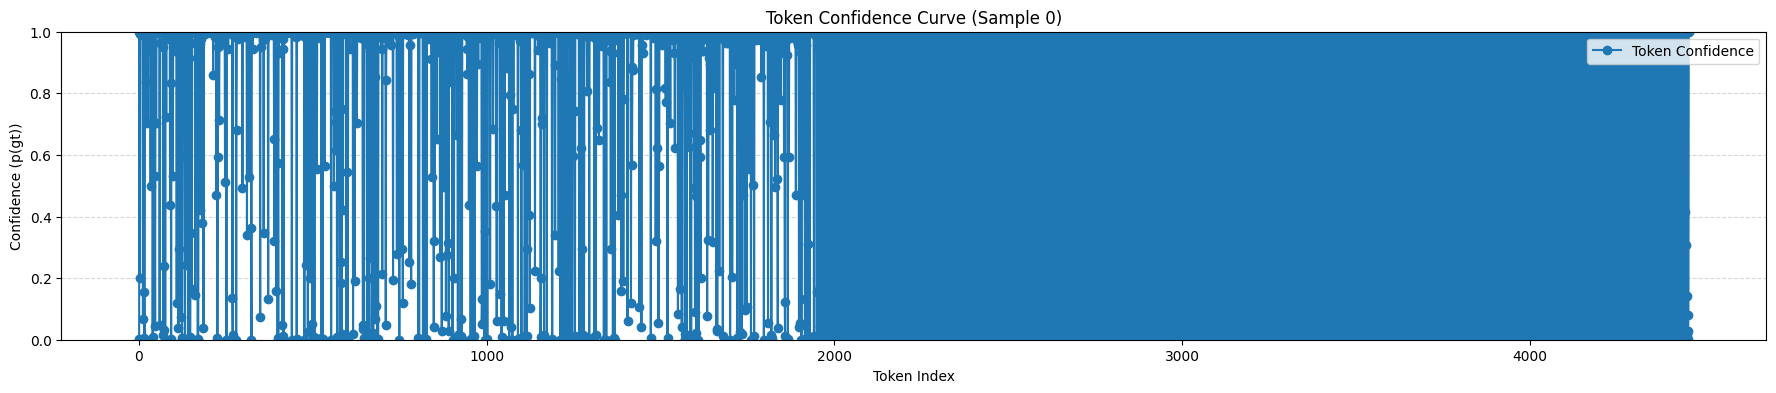

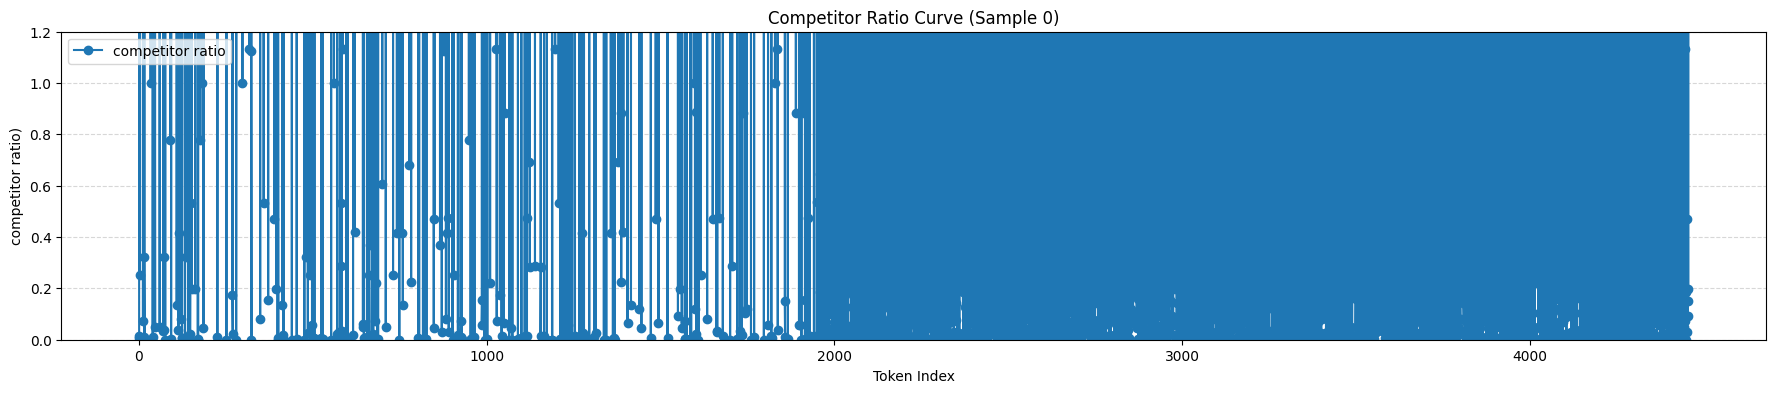

In [15]:
import matplotlib.pyplot as plt

# 选择一个样本（例如 batch 的第 0 个）
b = 0
conf = confidences[b].detach().cpu().float()
valid_mask = mask[b].detach().cpu()

# 仅绘制有效 token（非 pad）
conf = conf[valid_mask]

plt.figure(figsize=(22, 4))
plt.plot(range(len(conf)), conf, marker='o', label='Token Confidence')
plt.title(f"Token Confidence Curve (Sample {b})")
plt.xlabel("Token Index")
plt.ylabel("Confidence (p(gt))")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


ratio_to_other = ratio_to_otherb[b].detach().cpu()

ratio_to_other = ratio_to_other[valid_mask]

plt.figure(figsize=(22, 4))
plt.plot(range(len(conf)), ratio_to_other, marker='o', label='competitor ratio')
plt.title(f"Competitor Ratio Curve (Sample {b})")
plt.xlabel("Token Index")
plt.ylabel("competitor ratio)")
plt.ylim(0, 1.2)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [16]:
import pandas as pd
def _to_float(x):
    try:
        return float(x.item() if hasattr(x, "item") else x)
    except Exception:
        return x

def _tokens_to_str(tokens):
    if type(tokens)==str:
        return tokens
    try:
        return " ".join(tokens)
    except Exception:
        return str(tokens)

seq = gt_tokens[1:]

rows = []
#for i in range(len(tokens)-1, confidences.shape[-1]):
for i in range(0, confidences.shape[-1]):
    if _to_float(ratio_to_otherb[0][i]) < 1:
        rows.append({
            "idx": i,
            "confidence": _to_float(confidences[0][i]),
            "ratio": _to_float(ratio_to_otherb[0][i]),
            "prev_5": _tokens_to_str(seq[i-3:i]),
            "token_i": _tokens_to_str(seq[i]),
            "next_4": _tokens_to_str(seq[i+1:i+3]),
            "competitor token": decode_sequence([competitor_id[0,i].item()],token_mapping)[0],
        })

df = pd.DataFrame(rows, columns=["idx", "confidence", "ratio", "prev_5", "token_i", "next_4","competitor token"])

print(len(rows))
# 1) 终端打印“表格”（等宽文本）
print(df.to_string(index=False))


2053
 idx   confidence        ratio                                  prev_5      token_i                       next_4 competitor token
   0 3.494263e-03 5.615234e-03                                             object11   [(63, 48, 1), (63, 48, 2)]          unlabel
   1 1.583099e-04 1.519775e-02                                          (63, 48, 1)   [(63, 48, 2), (63, 48, 3)]       (18, 1, 1)
   3 2.011719e-01 2.519531e-01  ['object11', (63, 48, 1), (63, 48, 2)]  (63, 48, 3)   [(63, 49, 1), (63, 49, 2)]      (63, 49, 1)
  12 6.787109e-02 7.275391e-02 [(63, 50, 2), (63, 50, 3), (63, 50, 4)]  (63, 51, 1)   [(63, 51, 2), (63, 51, 3)]      (63, 51, 2)
  15 1.562500e-01 3.242188e-01 [(63, 51, 1), (63, 51, 2), (63, 51, 3)]  (63, 51, 4)   [(63, 51, 5), (64, 47, 1)]      (64, 48, 1)
  16 5.584717e-03 1.031494e-02 [(63, 51, 2), (63, 51, 3), (63, 51, 4)]  (63, 51, 5)   [(64, 47, 1), (64, 47, 2)]      (64, 47, 1)
  17 1.025200e-04 1.335144e-04 [(63, 51, 3), (63, 51, 4), (63, 51, 5)]  (64, 47, 1)  

In [97]:
competitor_id.shape

torch.Size([1, 1955])